# Explore how many PCA Components to Keep and Hyperparameter Tuning

## Takeaways after running this notebook:
1. The accurace gain by searching over a larger range of n_components seems to be small (~1%-2% gain in testing AUROC on average), even when the range of n_components is selected for each query based on a heuristic around class balance.
2. There is a similar accurace gain when only the largest value in the range is used 
2. There is a larger performance gain if the l1_ratio is changed from 0.15 to 0 and the range of alpha is expanded (~5%-7% gain in testing AUROC on average) there isn't much performance gain if these parameters are changed independent of each other.

__Purpose__

As described in issue #106 (https://github.com/cognoma/machine-learning/issues/106), searching over a large range of n_components (number of PCA components) causes issues with both speed and memory and may also cause issues with overfitting. This notebook is an attempt to explore the relationship between the number of components returned by PCA, the other hyperparameters and classifier performance (AUROC). Ideally, we will be able to automatically select a range of n_components to search across based on the specifics of the query. The assumption is that for the lower number of positive samples (and/or the less total samples)... the less n-components to include (i.e. a query with only 40 positive samples would use a classifer that does GridSearchCV with n_components = [30, 40, 50] whereas a query with 1,000 positive samples would use a classifier that does GridSearchCV with n_components = [100, 200, 300] _just random numbers for purpose of illustration_). This notebook attempts to provide some basis for selecting the range of n_components.


__Assumptions/Notes:__

This notebook differs from the current classifier in a number of ways including:
1. In this notebook, PCA is performed on the entire training set prior to cross-validation rather than performed on each individual cross-validation split. This is done for simplicity and to save time and memory.
2. In this notebook, the covariates data is not used (for now at least).


__To Do:__

1. Evaluate queries that only use a subset of diseases or a single disease.
2. Try to include the covariates data and see how that affects things.
3. Some additional evaluation and... select a final setup.

## Outline:
1. Imports, constants and load the data
2. Test Train split and perform PCA
3. Build the querry set
4. Evaluate queries with all samples (i.e. all diseases) and varying number of positives
 - a. Define some helper functions
 - b. See how the parameters are related using the current setup
 - c. Evaluate how changing some of the parameters effects performance
5. TO DO: Evaluate queries that only use a subset of diseases or a single disease


## 1. Imports, constants and load the data

In [1]:
import os
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from IPython.display import display

In [2]:
RANDOMSEED = 0

In [3]:
%%time
# Load the data
try: 
    path = os.path.join('download', 'expression-matrix.pkl')
    X = pd.read_pickle(path)
except:
    path = os.path.join('download', 'expression-matrix.tsv.bz2')
    X = pd.read_table(path, index_col=0)

try:
    path = os.path.join('download', 'mutation-matrix.pkl')
    y = pd.read_pickle(path)
except:
    path = os.path.join('download', 'mutation-matrix.tsv.bz2')
    y = pd.read_table(path, index_col=0)

Wall time: 6.22 s


## 2. Test Train split and perform PCA

In [4]:
# Test Train split
X_train, X_test, y_train_allgenes, y_test_allgenes = train_test_split(X, y, test_size=0.2, random_state=RANDOMSEED)

In [5]:
%%time
scaler = StandardScaler()
pca = PCA(n_components = 1000, random_state = RANDOMSEED)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca.fit(X_train_scaled)
X_train = pca.transform(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pca.transform(X_test_scaled)

Wall time: 1min 12s


## 3. Build the query set

In [6]:
# List of genes to iterate over (from brankaj's notebook: 
# https://github.com/cognoma/machine-learning/blob/master/explore/Classifier_results-different_genes.ipynb)
genes_LungCancer = {
    '207': 'AKT1', 
    '238': 'ALK',  
    '673': 'BRAF', 
    '4921':'DDR2',
    '1956':'EGFR',
    '2064':'ERBB2',
    '3845':'KRAS',
    '5604':'MAP2K1',
    '4893':'NRAS',
    '5290':'PIK3CA',
    '5728':'PTEN',
    '5979':'RET',
    # '6016':'RIT1', (removed because too few positives)
    '6098':'ROS1',
}

genes_TumorSuppressors = {
    '324': 'APC',  
    '672': 'BRCA1',  
    '675': 'BRCA2',
    '1029':'CDKN2A',
    '1630':'DCC',
    '4089':'SMAD4',
    '4087':'SMAD2',
    '4221':'MEN1',
    '4763':'NF1',
    '4771':'NF2',
    '7157':'TP53', 
    '5728':'PTEN', 
    '5925':'RB1',
    '7428':'VHL',
    '7486':'WRN',
    '7490':'WT1',
}

genes_Oncogenes = {
    #'5155':'PDGFB', #growth factor (removed because too few positives)
    '5159':'PDGFRB', #growth factor 
    '3791':'KDR', #receptor tyrosine kinases
    '25':'ABL1', #Cytoplasmic tyrosine kinases
    '6714':'SRC', #Cytoplasmic tyrosine kinases
    '5894':'RAF1',#cytoplasmic serine kinases
    '3265':'HRAS',#regulatory GTPases
    '4609':'MYC',#Transcription factors
    #'2353':'FOS',#Transcription factors (removed because too few positives)
    
}

list_of_genes = (list(genes_LungCancer.keys()) + list(genes_TumorSuppressors.keys()) + 
    list(genes_Oncogenes.keys()))

In [7]:
list_of_genes_positives = []
for gene in list_of_genes:
    y_temp = y_train_allgenes[gene]
    list_of_genes_positives.append(y_temp.value_counts(True)[1]*len(y_train_allgenes))
list_of_genes = [gene for _,gene in sorted(zip(list_of_genes_positives, list_of_genes))]

## 4. Evaluate queries with all samples (i.e. all diseases) and varying number of positives

### 4.a. Define some helper functions

In [8]:
def variance_scorer(x, y):
    """    
    Get the variance for each column of X.
    
    Because principal components have decreasing variance
    (i.e. PC4 has less variance than PC3 which has less variance
    than PC2 etc.), we can use this function in SelectKBest to select
    only the top X number of principal components.
    
    """
    scores = [np.var(column) for column in x.T]
    return scores, np.array([np.NaN]*len(scores))

In [9]:
def evaluate_classifier(X_train, X_test,
                        y, y_train_allgenes, y_test_allgenes,
                        list_of_genes,
                        set_k_range, k_function,
                        alpha_range, 
                        l1_ratio):
    
    ''' Run a classifier setup on a set of queries.
    
        Loop through each query; train and test the classifier using the
        hyperparameters input as parameters; populate the metrics dictionary
        with some metrics of which parameters were selected and how well
        the classifier did for that query.
    '''
    
    # A dictionary to hold the performance metrics.
    metrics_dict = {}
    
    # Loop through each query; train and test the classifer; populate the metrics dictionary.
    for gene in list_of_genes:
        
        # Train and test the classifier.
        
        y_gene = y[gene]
        y_train = y_train_allgenes[gene]
        y_test = y_test_allgenes[gene]
        num_positives = int(y_gene.value_counts(True)[1]*len(y_gene))
        if set_k_range:
            k_range = set_k_range
        else:
            k_range = k_function(num_positives)     
        # Parameter Sweep for Hyperparameters
        param_grid = {
            'select__k': k_range,
            'classify__loss': ['log'],
            'classify__penalty': ['elasticnet'],
            'classify__alpha': alpha_range,
            'classify__l1_ratio': l1_ratio,
        }
        pipeline = Pipeline(steps=[
            ('select', SelectKBest(variance_scorer)),
            ('classify', SGDClassifier(random_state=RANDOMSEED, class_weight='balanced'))
        ])
        cv_pipeline = GridSearchCV(estimator=pipeline, 
                                   param_grid=param_grid,
                                   n_jobs=1, 
                                   scoring='roc_auc')
        cv_pipeline.fit(X=X_train, y=y_train)
        y_pred_train = cv_pipeline.decision_function(X_train)
        y_pred_test = cv_pipeline.decision_function(X_test)
        # Get ROC info.
        def get_threshold_metrics(y_true, y_pred):
            roc_columns = ['fpr', 'tpr', 'threshold']
            roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
            roc_df = pd.DataFrame.from_items(roc_items)
            auroc = roc_auc_score(y_true, y_pred)
            return {'auroc': auroc, 'roc_df': roc_df}
        metrics_train = get_threshold_metrics(y_train, y_pred_train)
        metrics_test = get_threshold_metrics(y_test, y_pred_test)

        # Populate the metrics dictionary.

        # Get metrics for the classifier.
        overfit = metrics_train['auroc'] - metrics_test['auroc']
        # Understand how the parameter grid worked... any params at the edge?
        if cv_pipeline.best_params_['select__k'] == min(param_grid['select__k']):
            n_comp_status = 'min'
        elif cv_pipeline.best_params_['select__k'] == max(param_grid['select__k']):
            n_comp_status = 'max'
        else:
            n_comp_status = 'OK'
        if cv_pipeline.best_params_['classify__alpha'] == min(param_grid['classify__alpha']):
            alpha_status = 'min'
        elif cv_pipeline.best_params_['classify__alpha'] == max(param_grid['classify__alpha']):
            alpha_status = 'max'
        else:
            alpha_status = 'OK'
        metrics = {'num_positive': num_positives,
                   'train_auroc': metrics_train['auroc'], 
                   'test_auroc': metrics_test['auroc'],
                   'n_components': cv_pipeline.best_params_['select__k'], 
                   'alpha': cv_pipeline.best_params_['classify__alpha'],
                   'overfit': overfit,
                   'n_comp_status': n_comp_status,
                   'alpha_status': alpha_status
                  }
        # Add the metrics to the dictonary.
        metrics_dict[gene] = metrics
    # Change the metrics dict into a formatted pandas dataframe.
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df = metrics_df.T
    metrics_df.sort_values(by='num_positive', ascending=True, inplace=True)
    metrics_df = metrics_df[['num_positive', 'n_components','n_comp_status', 'alpha', 'alpha_status','train_auroc', 'test_auroc', 'overfit']]
    
    return(metrics_df)

In [10]:
def display_stats(metrics_df, metrics_df_tocompare = None, verbose = True):
    if verbose:
        display(metrics_df)
    # Summary for metrics_df    
    metrics_df.loc['mean'] = metrics_df.mean()
    metrics_df.loc['median'] = metrics_df.median()
    metrics_df_summary = metrics_df.loc[['mean', 'median']]
    metrics_df_summary = metrics_df_summary[['num_positive', 'n_components', 'alpha', 'train_auroc', 'test_auroc','overfit']]
    display(metrics_df_summary)
    if metrics_df_tocompare is not None:
        # Summary for metrics_df_tocompare
        metrics_df_tocompare.loc['mean'] = metrics_df_tocompare.mean()
        metrics_df_tocompare.loc['median'] = metrics_df_tocompare.median()
        metrics_df_to_compare_summary = metrics_df_tocompare.loc[['mean', 'median']]
        # Evaluate the improvement
        mean_testing_auroc_improvement = metrics_df_summary['test_auroc']['mean'] - metrics_df_to_compare_summary['test_auroc']['mean']
        median_testing_auroc_improvement = metrics_df_summary['test_auroc']['median'] - metrics_df_to_compare_summary['test_auroc']['median']
        mean_overfit_reduction = metrics_df_to_compare_summary['overfit']['mean'] - metrics_df_summary['overfit']['mean']
        median_overfit_reduction = metrics_df_to_compare_summary['overfit']['median'] - metrics_df_summary['overfit']['median']
        print('Mean testing Auroc improved by {:.2f}%'.format(mean_testing_auroc_improvement*100))
        print('Median testing Auroc improved by {:.2f}%'.format(median_testing_auroc_improvement*100))
        print('Mean overfitting reduced by {:.1f}%'.format(mean_overfit_reduction*100))
        print('Median overfitting reduced by {:.1f}%'.format(median_overfit_reduction*100))

### 4.b. See how the parameters are related using the current setup

In [11]:
%%time
metrics_df_current_setup = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [50, 100],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-3, 1)],
                                               l1_ratio = [0.15])
display_stats(metrics_df_current_setup, metrics_df_tocompare = None)

,num_positive,n_components,n_comp_status,alpha,alpha_status,train_auroc,test_auroc,overfit
6714,34,50,min,0.01,OK,0.689502,0.564129,0.125373
4609,37,50,min,0.01,OK,0.744421,0.443182,0.301239
207,38,50,min,0.01,OK,0.628019,0.395891,0.232128
5894,42,50,min,1,max,0.75881,0.672984,0.0858264
4087,48,100,max,0.01,OK,0.757118,0.733031,0.0240868
5604,55,100,max,0.1,OK,0.907156,0.508406,0.39875
4221,57,50,min,0.01,OK,0.726585,0.606066,0.12052
7490,58,50,min,0.01,OK,0.729814,0.565093,0.164721
4771,79,100,max,0.01,OK,0.871729,0.767271,0.104459
25,80,100,max,0.001,min,0.729904,0.54043,0.189474


,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,80,0.533543,0.77205,0.692798,0.0792519
median,137,100,0.766771,0.762968,0.700795,0.0610236


Wall time: 1min 7s


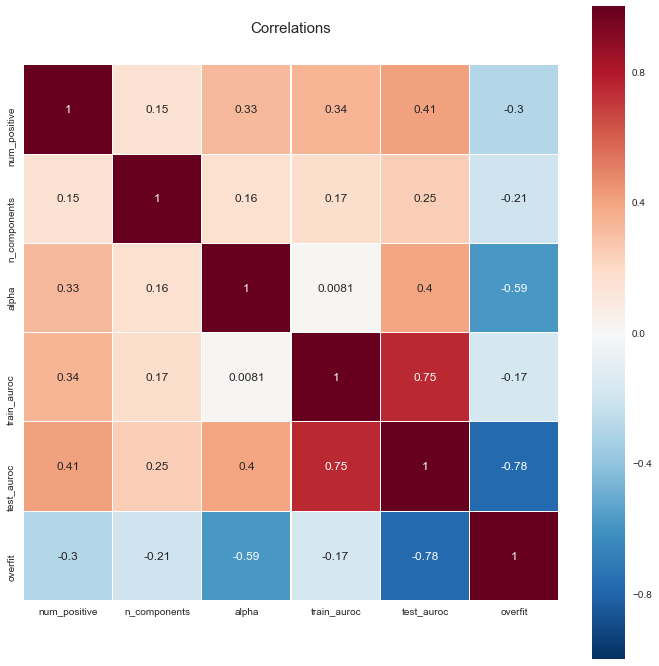

In [12]:
# Show how some of these metrics/parameters might be related
metrics_df_for_correlations = metrics_df_current_setup[['num_positive', 'n_components', 'alpha', 'train_auroc', 'test_auroc', 'overfit']]
plt.figure(figsize=(12,12))
plt.title('Correlations', y=1.05, size=15)
sns.heatmap(metrics_df_for_correlations.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, annot=True)
sns.plt.show()

### 4.c. Evaluate how changing some of the parameters effects performance

The three things I'd like to evaluate are n_components, alpha and l1_ratio

My thoughts, going from easiest to most difficult to evaluate...
 - alpha: just make the range larger if a lot of queries are at max or min (i.e. at the edge of the gridsearch space
 - l1_ratio: the two values that we've discussed are 0 and 0.15... just try both for different setups
 - n_components: try lists of varying size, try functions to auto select

#### Try all combos of:
#### k_range = [10, 20, 40, 80, 160, 320, 640]
#### alpha_range = [10** x for x in range(-10,10)]
#### and l1_ratio = 0

In [13]:
%%time
# k_range
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [10, 20, 40, 80, 160, 320, 640],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-3, 1)],
                                               l1_ratio = [0.15])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,261.143,0.347371,0.793946,0.705682,0.0882634
median,137,160,0.1,0.787152,0.707957,0.0707356


Mean testing Auroc improved by 1.27%
Median testing Auroc improved by 0.72%
Mean overfitting reduced by -1.0%
Median overfitting reduced by -1.0%
Wall time: 5min 4s


In [14]:
%%time
# k_max. Test if a range is even any better than just the largest number...
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [640],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-3, 1)],
                                               l1_ratio = [0.15])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,640,0.538429,0.833917,0.709258,0.124658
median,137,640,0.769214,0.852768,0.713322,0.0894777


Mean testing Auroc improved by 1.62%
Median testing Auroc improved by 1.25%
Mean overfitting reduced by -4.6%
Median overfitting reduced by -2.8%
Wall time: 2min 6s


Interesting, but maybe not too suprising. Looks like the range as opposed to just the max helps with overfitting but actually hurts with overall accurace

In [15]:
%%time
# l1_ratio
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [50, 100],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-3, 1)],
                                               l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,85.7143,0.494457,0.776175,0.6947,0.0814751
median,137,100,0.297229,0.776817,0.687523,0.0524966


Mean testing Auroc improved by 0.17%
Median testing Auroc improved by -1.33%
Mean overfitting reduced by -0.3%
Median overfitting reduced by 0.9%
Wall time: 1min 4s


In [16]:
%%time
# alpha_range
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [50, 100],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-10, 10)],
                                               l1_ratio = [0.15])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,78.5714,2.69206,0.7786,0.70246,0.0761406
median,137,100,1,0.774517,0.699582,0.0584197


Mean testing Auroc improved by 0.94%
Median testing Auroc improved by -0.12%
Mean overfitting reduced by 0.3%
Median overfitting reduced by 0.3%
Wall time: 3min 7s


In [17]:
%%time
# alpha_range and l1_ratio
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [50, 100],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-10, 10)],
                                               l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,94.2857,346141,0.829757,0.763774,0.0659825
median,137,100,55,0.830814,0.75685,0.0418654


Mean testing Auroc improved by 7.08%
Median testing Auroc improved by 5.61%
Mean overfitting reduced by 1.3%
Median overfitting reduced by 1.9%
Wall time: 2min 54s


In [18]:
%%time
# alpha_range and k_range
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [10, 20, 40, 80, 160, 320, 640],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-10, 10)],
                                               l1_ratio = [0.15])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,226.286,1.68035,0.777703,0.691562,0.0861411
median,137,160,0.1,0.763551,0.669836,0.0685817


Mean testing Auroc improved by -0.15%
Median testing Auroc improved by -3.10%
Mean overfitting reduced by -0.7%
Median overfitting reduced by -0.8%
Wall time: 19min 20s


In [19]:
%%time
# k_range and l1_ratio
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [10, 20, 40, 80, 160, 320, 640],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-3, 1)],
                                               l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,347.714,0.537914,0.825945,0.709964,0.115981
median,137,320,0.768957,0.86,0.718275,0.10949


Mean testing Auroc improved by 1.69%
Median testing Auroc improved by 1.75%
Mean overfitting reduced by -3.7%
Median overfitting reduced by -4.8%
Wall time: 5min 12s


In [20]:
%%time
# All three: k_range, alpha_range and l1_ratio
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [10, 20, 40, 80, 160, 320, 640],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-10, 10)],
                                               l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,382.286,3.14305e+06,0.851795,0.77483,0.0769651
median,137,320,10,0.868835,0.758737,0.0592118


Mean testing Auroc improved by 8.18%
Median testing Auroc improved by 5.79%
Mean overfitting reduced by 0.2%
Median overfitting reduced by 0.2%
Wall time: 17min 21s


In [21]:
%%time
# All three: k_range, alpha_range and l1_ratio... Again this time only use the max of the k_range
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = [640],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-10, 10)],
                                               l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,640,3.14889e+07,0.870003,0.771827,0.0981763
median,137,640,55,0.872664,0.755183,0.0634218


Mean testing Auroc improved by 7.88%
Median testing Auroc improved by 5.44%
Mean overfitting reduced by -1.9%
Median overfitting reduced by -0.2%
Wall time: 7min 13s


With the larger aplha range and l1_ratio it looks like having the range of k as opposed to just the max helps with both overall performance as well as overfitting

### Use a function to automatically select the parameter space to search

In [22]:
# k_range function
def k_func(num_positives):
    if num_positives < 50:
        k_range = [6, 8, 10, 14, 20, 28]
    elif num_positives < 100:
        k_range = [10, 15, 20, 30, 50, 80]
    elif num_positives < 200:
        k_range = [15, 25, 50, 75, 100, 175]
    elif num_positives < 500:
        k_range = [60, 100, 150, 250, 400] # Tried 30, 60, 100, 150
    else:
        k_range = [100, 200, 400, 800]
    return(k_range)

In [23]:
%%time
# k_range func
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = None,
                                               k_function = k_func,
                                               alpha_range = [10** x for x in range(-3, 1)],
                                               l1_ratio = [0.15])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,166.314,0.464371,0.753238,0.695742,0.0574961
median,137,100,0.1,0.755169,0.691246,0.0582237


Mean testing Auroc improved by 0.27%
Median testing Auroc improved by -0.95%
Mean overfitting reduced by 2.1%
Median overfitting reduced by 0.3%
Wall time: 3min 42s


In [24]:
%%time
# k_range func with larger alpha range
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = None,
                                               k_function = k_func,
                                               alpha_range = [10** x for x in range(-10, 10)],
                                               l1_ratio = [0.15])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,169.6,1.4526,0.766604,0.7085,0.0581044
median,137,80,0.1,0.761007,0.705845,0.0491028


Mean testing Auroc improved by 1.55%
Median testing Auroc improved by 0.50%
Mean overfitting reduced by 2.1%
Median overfitting reduced by 1.2%
Wall time: 11min 20s


In [25]:
%%time
# k_range func with larger alpha range and l1_ratio = 0
metrics_df = evaluate_classifier(X_train = X_train,
                                               X_test = X_test,
                                               y = y,
                                               y_train_allgenes = y_train_allgenes,
                                               y_test_allgenes = y_test_allgenes,
                                               list_of_genes = list_of_genes,
                                               set_k_range = None,
                                               k_function = k_func,
                                               alpha_range = [10** x for x in range(-10, 10)],
                                               l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup)

,num_positive,n_components,n_comp_status,alpha,alpha_status,train_auroc,test_auroc,overfit
6714,34,28,max,1000,OK,0.771098,0.574074,0.197024
4609,37,20,OK,1000,OK,0.816241,0.582438,0.233803
207,38,28,max,100,OK,0.774728,0.74957,0.0251575
5894,42,14,OK,1000,OK,0.741009,0.702819,0.0381898
4087,48,14,OK,1000,OK,0.768437,0.742946,0.0254908
5604,55,80,max,10,OK,0.926328,0.703114,0.223214
4221,57,30,OK,1000,OK,0.722205,0.587625,0.13458
7490,58,20,OK,1000,OK,0.715819,0.718188,-0.00236926
4771,79,80,max,100,OK,0.857419,0.818807,0.0386118
25,80,80,max,1000000000,max,0.704129,0.706623,-0.00249354


,num_positive,n_components,alpha,train_auroc,test_auroc,overfit
mean,256.657,223.543,2.88574e+07,0.839741,0.778769,0.0609711
median,137,175,100,0.831504,0.755449,0.0478721


Mean testing Auroc improved by 8.57%
Median testing Auroc improved by 5.47%
Mean overfitting reduced by 1.8%
Median overfitting reduced by 1.3%
Wall time: 10min 9s
